In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [54]:
# Load data
data = pd.read_csv('/content/enhanced_traffic_data.csv')
data['hour'] = pd.to_datetime(data['hour'], format='%m/%d/%Y %H:%M', dayfirst=False)  # Correct format specifier
data.set_index('hour', inplace=True)

In [55]:
data.head(10)

,traffic_volume,day_of_week,hour.1,day_of_year,is_weekend,city
hour,,,,,,
2020-01-01 00:00:00,202,2,0H,ka1,#0aaa,california
2020-01-01 01:00:00,%^&*HAa535,!!@$##2,1H,1$#,0@%,california
NaT,NaN,NaN,NaN,NaN,NaN,california
2020-01-01 02:00:00,960,(()*&2,2H,1#,##0,california
NaT,NaN,NaN,NaN,NaN,NaN,california
2020-01-01 03:00:00,#$%&^(370,2,3H,1,0,california
2020-01-01 04:00:00,206,2,4H,1,&*0,california
2020-01-01 05:00:00,171,2,5H,1@@,aaa0,california
2020-01-01 06:00:00,800,2,6,1$#ka,0,california


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8777 entries, 2020-01-01 00:00:00 to 2020-12-31 00:00:00
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   traffic_volume  8767 non-null   object
 1   day_of_week     8767 non-null   object
 2   hour.1          8767 non-null   object
 3   day_of_year     8767 non-null   object
 4   is_weekend      8767 non-null   object
 5   city            8777 non-null   object
dtypes: object(6)
memory usage: 480.0+ KB


In [57]:
# Drop nulls
data = data.dropna()

In [58]:
data.isnull().sum()

,0
traffic_volume,0
day_of_week,0
hour.1,0
day_of_year,0
is_weekend,0
city,0


In [59]:
data.duplicated().sum()

6

In [60]:
# drop duplicates
data = data.drop_duplicates()
data.duplicated().sum()

0

In [61]:
# clean data from special characters
columns = ['traffic_volume','day_of_week','hour.1','day_of_year','is_weekend']
chars = "HAak&!@#%^$*()-"
for i in columns:
  for j in chars:
    data[i] = data[i].str.replace(j,"")

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8761 entries, 2020-01-01 00:00:00 to 2020-12-31 00:00:00
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   traffic_volume  8761 non-null   object
 1   day_of_week     8761 non-null   object
 2   hour.1          8761 non-null   object
 3   day_of_year     8761 non-null   object
 4   is_weekend      8761 non-null   object
 5   city            8761 non-null   object
dtypes: object(6)
memory usage: 479.1+ KB


In [63]:
data.head(5)

,traffic_volume,day_of_week,hour.1,day_of_year,is_weekend,city
hour,,,,,,
2020-01-01 00:00:00,202,2,0,1,0,california
2020-01-01 01:00:00,535,2,1,1,0,california
2020-01-01 02:00:00,960,2,2,1,0,california
2020-01-01 03:00:00,370,2,3,1,0,california
2020-01-01 04:00:00,206,2,4,1,0,california


In [64]:
data = data.drop('city',axis=1)

In [65]:
# Add temporal features
data['day_of_week'] = data.index.dayofweek
data['hour.1'] = data.index.hour
data['day_of_year'] = data.index.dayofyear
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [67]:
data['traffic_volume'] = data['traffic_volume'].astype(int)

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8761 entries, 2020-01-01 00:00:00 to 2020-12-31 00:00:00
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   traffic_volume  8761 non-null   int64
 1   day_of_week     8761 non-null   int32
 2   hour.1          8761 non-null   int32
 3   day_of_year     8761 non-null   int32
 4   is_weekend      8761 non-null   int64
dtypes: int32(3), int64(2)
memory usage: 308.0 KB


In [70]:
# Select features and target
features = ['traffic_volume', 'day_of_week', 'hour.1', 'day_of_year', 'is_weekend']  # Adjust if necessary
data = data[features]  # Focus on relevant columns

In [71]:
# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [72]:
# Split data
cutoff_date = '2020-08-01'
train = data[:cutoff_date]
test = data[cutoff_date:]

In [74]:
# Set look_back period
look_back = 24  # Adjust based on your requirements

# Prepare X_train and y_train consistently
X_train = []
y_train = []

for i in range(look_back, len(train)):
    X_train.append(data_scaled[i - look_back:i, :])  # Collect past 'look_back' samples
    y_train.append(data_scaled[i, 0])  # Assuming the first column is the target (traffic_volume)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Ensure temporal features are aligned by slicing correctly
temporal_features_train = train[['day_of_week', 'hour.1', 'day_of_year', 'is_weekend']].iloc[look_back:].reset_index(drop=True)

# Check lengths to confirm alignment
print("X_train length:", len(X_train))
print("Temporal Features length:", len(temporal_features_train))
print("y_train length:", len(y_train))


X_train length: 5112
Temporal Features length: 5112
y_train length: 5112


In [75]:
# Define inputs
input_shape_x = Input(shape=(X_train.shape[1], X_train.shape[2]))  # Shape for X_train
input_shape_temporal = Input(shape=(temporal_features_train.shape[1],))  # Shape for temporal features

# Define LSTM layers
lstm_out = LSTM(100, return_sequences=True)(input_shape_x)  # Increased units in LSTM layer
lstm_out = LSTM(50, return_sequences=True)(lstm_out)  # Another LSTM layer
lstm_out = LSTM(25)(lstm_out)  # Final LSTM layer

# Add Dropout for regularization
from tensorflow.keras.layers import Dropout
lstm_out = Dropout(0.2)(lstm_out)  # Dropout layer to prevent overfitting

# Concatenate with temporal features
concatenated = Concatenate()([lstm_out, input_shape_temporal])

# Add more Dense layers
dense_out = Dense(64, activation='relu')(concatenated)  # First dense layer
dense_out = Dropout(0.2)(dense_out)  # Dropout layer
dense_out = Dense(32, activation='relu')(dense_out)  # Second dense layer
dense_out = Dropout(0.2)(dense_out)  # Dropout layer

# Output layer
output = Dense(1)(dense_out)

# Create model
model = Model(inputs=[input_shape_x, input_shape_temporal], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')  # Compile model


In [76]:
# Fit the model if everything is aligned
if len(X_train) == len(temporal_features_train) == len(y_train):
    print("Data is aligned. Proceeding to model training.")

    # Adding an EarlyStopping callback to avoid long training times on a stuck model
    from tensorflow.keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

    model.fit([X_train, temporal_features_train], y_train, epochs=10, batch_size=32, callbacks=[early_stopping])
else:
    print(f"Mismatch in data sizes - X_train: {len(X_train)}, Temporal Features: {len(temporal_features_train)}, y_train: {len(y_train)}")


Data is aligned. Proceeding to model training.
Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 54.9289
Epoch 2/10
 39/160 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 3.9881

KeyboardInterrupt: 

114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step


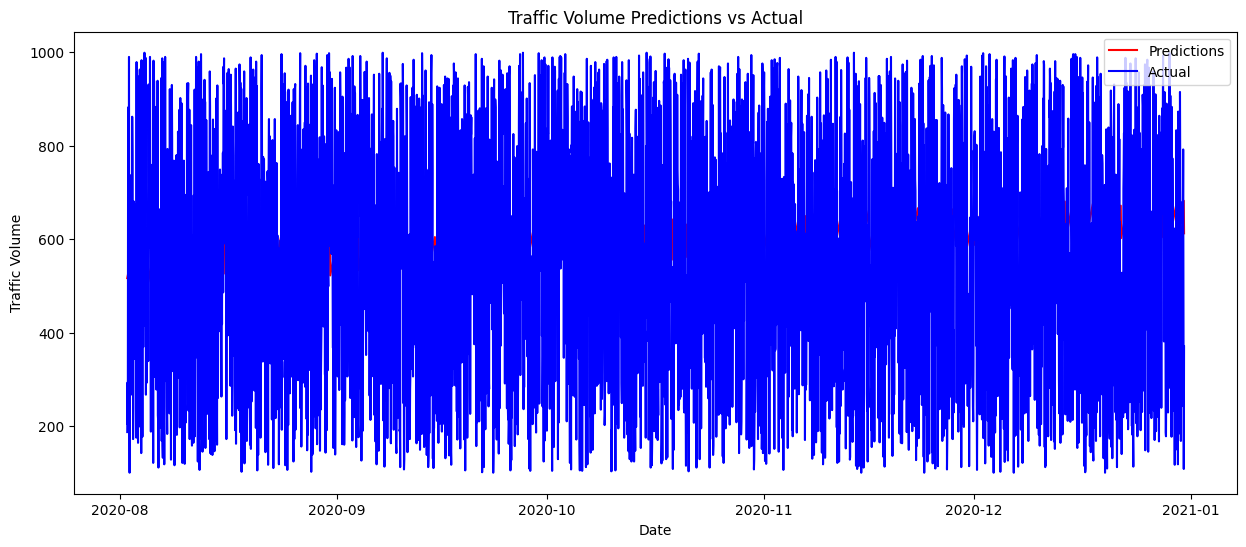

In [ ]:
# Evaluate the model on test data (not shown in previous cells)
X_test = []
y_test = []

for i in range(look_back, len(test)):
    X_test.append(data_scaled[i - look_back:i, :])
    y_test.append(data_scaled[i, 0])  # Assuming the first column is the target (traffic_volume)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Prepare temporal features for test
temporal_features_test = test[['day_of_week', 'hour', 'day_of_year', 'is_weekend']].iloc[look_back:].reset_index(drop=True)

# Make predictions
predictions = model.predict([X_test, temporal_features_test])

# Inverse transform predictions to original scale
predictions_inverse = scaler.inverse_transform(np.concatenate((predictions, temporal_features_test), axis=1))[:, 0]

# Compare predictions with actual values
# (Assuming you want to visualize the results)
plt.figure(figsize=(15, 6))
plt.plot(test.index[look_back:], predictions_inverse, label='Predictions', color='red')
plt.plot(test.index[look_back:], test['traffic_volume'].values[look_back:], label='Actual', color='blue')
plt.title('Traffic Volume Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()


In [ ]:
# Function to make a prediction for a specific future date
def predict_future_traffic(date, hour):
    # Convert the date to datetime format
    future_date = pd.to_datetime(date)

    # Generate temporal features for the future date
    day_of_week = future_date.dayofweek
    day_of_year = future_date.dayofyear
    is_weekend = 1 if day_of_week >= 5 else 0  # 1 if Saturday/Sunday, else 0

    # Create the input array for the model for the look_back period
    input_data = np.zeros((look_back, len(features)))  # Initialize with zeros

    # Fill the input data with past features
    for i in range(look_back):
        past_date = future_date - timedelta(hours=look_back - i)
        past_day_of_week = past_date.dayofweek
        past_day_of_year = past_date.dayofyear
        past_is_weekend = 1 if past_day_of_week >= 5 else 0
        input_data[i] = [0, past_day_of_week, past_date.hour, past_day_of_year, past_is_weekend]  # Placeholder traffic volume

    # Scale the input data
    input_data_scaled = scaler.transform(input_data)

    # Reshape for the model
    input_data_scaled = input_data_scaled.reshape((1, look_back, len(features)))

    # Make the prediction
    prediction = model.predict([input_data_scaled, np.array([[day_of_week, hour, day_of_year, is_weekend]])])

    # Inverse transform to get the actual traffic volume
    predicted_traffic = scaler.inverse_transform(np.concatenate([prediction, np.zeros((1, len(features) - 1))], axis=1))[:, 0]
    return predicted_traffic[0]

# Example usage: predict traffic volume for a specific future date
future_date = '2023-09-2'  # Replace with your desired future date
hour = 12                    # Specify the hour you want to predict
predicted_traffic_volume = predict_future_traffic(future_date, hour)
print(f'Predicted traffic volume for {future_date} at {hour}:00: {predicted_traffic_volume}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Predicted traffic volume for 2023-09-2 at 12:00: 573.0908237695694
